In [ ]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2LMHeadModel
import matplotlib.pyplot as plt
import random



In [ ]:
!python --version


Python 3.11.12


#Creating the CFG dataset

In [ ]:
# Grammar dict όπως πριν
grammar = {
    'root': [['20','21'], ['20','19','21'], ['21','19','19'], ['20','20']],
    '19'  : [['18','16','18'], ['17','18'], ['18','18']],
    '20'  : [['16','16'], ['16','17'], ['17','16','18']],
    '21'  : [['18','17'], ['17','16'], ['16','17','18'], ['16','18']],
    '16'  : [['15','15'], ['13','15','13'], ['14','13'], ['14','14']],
    '17'  : [['14','15'], ['15','14']],
    '18'  : [['14','15','13'], ['15','13','13'], ['13','15']],
    '13'  : [['11','12'], ['12','11','12'], ['10','12','11']],
    '14'  : [['10','12'], ['12','10','12'], ['12','11'], ['10','12','12']],
    '15'  : [['10','11','11'], ['11','11','10'], ['10','10'], ['12','12','11']],
    '10'  : [['8','9','9'], ['9','7','9'], ['7','9','9']],
    '11'  : [['8','8'], ['9','7'], ['9','7','7']],
    '12'  : [['7','9','7'], ['9','8'], ['8','8','9']],
    '7'   : [['2','2','1'], ['3','2','2'], ['3','1','2'], ['3','2']],
    '8'   : [['3','1','1'], ['1','2'], ['3','3','1']],
    '9'   : [['1','2','1'], ['3','3'], ['1','1']],
    # terminals:   '1','2','3','8','9','10',...
}

def sample_rec(symbol: str, depth: int, max_small_depth: int|None) -> list[str]:
    """
    Αν είμαστε σε 'βάθος' equal max_small_depth,
    θα διαλέξουμε μόνο παραγωγές που οδηγούν απευθείας σε terminals,
    δηλαδή εκείνες όπου κάθε σύμβολο δεν είναι κλειδί του grammar.
    Αν max_small_depth is None, δεν περιορίζουμε ποτέ.
    """
    # terminal
    if symbol not in grammar:
        return [symbol]

    prods = grammar[symbol]
    # φιλτράρουμε παραγωγές αν χτύπησε το όριο
    if max_small_depth is not None and depth >= max_small_depth:
        filtered = [p for p in prods if all(sym not in grammar for sym in p)]
        if filtered:
            prods = filtered

    prod = random.choice(prods)
    out: list[str] = []
    for sym in prod:
        out += sample_rec(sym, depth+1, max_small_depth)
    return out

def sample_sequence(max_small_depth: int|None = None) -> str:
    tokens = sample_rec('root', depth=0, max_small_depth=max_small_depth)
    return ''.join(tokens)


# —— Εκτύπωση 10 “μικρών” παραδειγμάτων με max_small_depth=2 ——
for _ in range(10):
    s = sample_sequence(max_small_depth=2)
    print(f"{s}  (len={len(s)})")

# —— Γέμισμα full dataset (20M) χωρίς όριο βάθους ——
N = 20_000_000
with open('/content/cfg3f_dataset.txt', 'w') as f:
    for _ in range(N):
        f.write(sample_sequence(max_small_depth=None) + '\n')
        print(_)
print("Finished! /content/cfg3f_dataset.txt is ready.")


##Over encoding function
This function will replace the empedding layer of the GPT2 model and will introduce over encoding: the n-gram tokenization in the input of the model.

In [ ]:
class OEEmbedding(nn.Module):
    def __init__(self, vocab_size, model_dim, m, max_ngram=3, k=4, pad_token_id=3):
        super().__init__()
        self.vocab_size   = vocab_size
        self.model_dim    = model_dim
        self.m            = m
        self.max_ngram    = max_ngram
        self.k            = k
        self.pad_token_id = pad_token_id

        # 1-gram embeddings
        self.e1 = nn.Embedding(vocab_size, model_dim)

        # compute slice dimension and total number of ngram modules
        slice_dim = model_dim // (k * (max_ngram - 1))
        total     = (max_ngram - 1) * k

        # n-gram embedding tables and projection layers
        self.ngram_embeddings = nn.ModuleList([
            nn.Embedding(m + 2 * idx, slice_dim)
            for idx in range(total)
        ])
        self.ngram_projs = nn.ModuleList([
            nn.Linear(slice_dim, model_dim)
            for _ in range(total)
        ])

    def forward(self, input_ids):
        # base token embeddings
        x = self.e1(input_ids)
        ngram_ids = input_ids.clone().long()

        # for each n-gram order 2…max_ngram
        for n in range(2, self.max_ngram + 1):
            shifted_ids = input_ids.clone()
            for i in range(1, n):
                rolled = input_ids.roll(shifts=i, dims=1)
                rolled[:, :i] = self.pad_token_id
                shifted_ids += rolled * (self.vocab_size ** i)
            ngram_ids = shifted_ids

            # apply k different hash embeddings & projections
            for j in range(self.k):
                idx  = (n - 2) * self.k + j
                size = self.m + 2 * idx
                ids_mod = ngram_ids % size

                # debug check
                if (ids_mod >= size).any():
                    raise RuntimeError(f"Out-of-range ngram id: max {ids_mod.max()} ≥ size {size}")

                h      = self.ngram_embeddings[idx](ids_mod)
                h_proj = self.ngram_projs[idx](h)
                x     += h_proj

        return x


# Loading the dataset of the CFG
Each line has a sequence which we will give to the model as input.

In [ ]:
#loading the dataset
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/cfg3f_200k.txt"




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open(path, 'r') as f:
    lines = [line.strip() for line in f.readlines()]

print(f'Total sentences: {len(lines)}')


Total sentences: 200000


# Tokenization

In [ ]:
class CFGTokenizer:
    def __init__(self, chars=['1', '2', '3']):
        # 1. Vocab creation
        self.vocab = {}
        idx = 0
        for ch in chars:
            self.vocab[ch] = idx
            idx += 1

        # 2. Add an index for PAD token
        self.vocab['<PAD>'] = idx  # it gets the last id (here is 3)

        # 3. Create the inverse vocabulary
        self.inv_vocab = {}
        for ch, i in self.vocab.items():
            self.inv_vocab[i] = ch

    def encode(self, text):
        # Give each character its index
        ids = []
        for ch in text:
            ids.append(self.vocab[ch])
        return ids

    def decode(self, ids):
        # Inverse (omit PAD)
        chars = []
        for i in ids:
            ch = self.inv_vocab[i]
            if ch != '<PAD>':
                chars.append(ch)
        return ''.join(chars) #from list [1,2,3] to sequence 123


Our tokenizer:

In [ ]:
tokenizer = CFGTokenizer(chars=['1', '2', '3'])
vocab_size = len(tokenizer.vocab)
pad_token_id = tokenizer.vocab['<PAD>']
print("Vocab:", tokenizer.vocab)
print("vocab_size:", vocab_size)
print("pad_token_id:", pad_token_id)


Vocab: {'1': 0, '2': 1, '3': 2, '<PAD>': 3}
vocab_size: 4
pad_token_id: 3


# Padding the sequences

In [ ]:
# Padding the sequences
def pad_sequences(seq_list, pad_token):
    max_len = max(len(seq) for seq in seq_list) #find the max length
    padded_seqs = [seq + [pad_token]*(max_len - len(seq)) for seq in seq_list] #fill with PAD token = 3 till we reach max length
    return torch.tensor(padded_seqs, dtype=torch.long)




In [ ]:
#each sequece is converted to a list of indexes
tokenized_data = [tokenizer.encode(line) for line in lines]


#splitting the data
train_data, val_data = train_test_split(tokenized_data, test_size=0.2, random_state=42)

#padding the sequences
train_tensor = pad_sequences(train_data, pad_token=pad_token_id)
val_tensor = pad_sequences(val_data, pad_token=pad_token_id)

#Data loaders
batch_size = 64
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)


#Function for accuracy evaluation

In [ ]:

def evaluate_accuracy(model, loader, pad_token_id):
    model.eval()
    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in loader:
            # load input_ids and move to device
            input_ids = batch[0].to(device)              # shape: [B, L]

            # prepare model inputs and targets
            model_inputs  = input_ids[:, :-1]            # tokens from position 0 to L-2
            target_tokens = input_ids[:, 1:]             # tokens from position 1 to L-1

            # forward pass through the model
            outputs       = model(model_inputs)
            logits        = outputs.logits               # shape: [B, L-1, V]
            predicted_ids = logits.argmax(dim=-1)        # predicted token ids, shape: [B, L-1]

            # create mask to ignore padding tokens in the targets
            non_pad_mask = (target_tokens != pad_token_id)  # shape: [B, L-1], bool

            # compare predictions to targets only where mask is True
            correct_preds = (predicted_ids == target_tokens) & non_pad_mask

            # accumulate counts
            total_correct += correct_preds.sum().item()
            total_tokens  += non_pad_mask.sum().item()

    # return accuracy (avoid division by zero)
    if total_tokens == 0:
        return 0.0
    return total_correct / total_tokens


# We will run the baseline model firstly, without replacing embedding layer.

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#Original gpt2 has 12 layers and 12 heads but we want 2.4 M parameters not the original
config = GPT2Config(
    vocab_size=4,
    pad_token_id=3,
    n_embd=128,
    n_layer=12,
    n_head=2,
    n_positions=750, #max length of tokens for each sequence

)


#model creation
model = GPT2LMHeadModel(config)


#Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4, betas=(0.9, 0.98),
    weight_decay=0.1
)

#Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

#Loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id)

model.to(device)


Using device: cuda


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(4, 128)
    (wpe): Embedding(750, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=512, nx=128)
          (c_proj): Conv1D(nf=128, nx=512)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=128, out_features=4, bias=False)
)

# We want 2.4M parameters like the paper:

In [ ]:
# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters:     {total_params:,}")


Total parameters:     2,476,032


#Training the baseline model

In [ ]:
#Training
epochs = 10


for epoch in range(epochs):
    model.train()
    total_loss = 0
    for (input_ids,) in train_loader:
        input_ids = input_ids.to(device)

        optimizer.zero_grad()

        # Access the logits tensor from the model's output object
        model_output = model(input_ids[:, :-1])
        logits = model_output.logits # Get the logits tensor

        labels = input_ids[:, 1:].reshape(-1)

        # Now reshape the actual logits tensor
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            labels
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)

    # Accuracy
    val_accuracy = evaluate_accuracy(model, val_loader, pad_token_id=pad_token_id)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Validation Generation Accuracy: {val_accuracy:.4f}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/10 | Train Loss: 0.9845 | Validation Generation Accuracy: 0.5568
Epoch 2/10 | Train Loss: 0.8643 | Validation Generation Accuracy: 0.5766
Epoch 3/10 | Train Loss: 0.8350 | Validation Generation Accuracy: 0.5851
Epoch 4/10 | Train Loss: 0.8199 | Validation Generation Accuracy: 0.5906
Epoch 5/10 | Train Loss: 0.8093 | Validation Generation Accuracy: 0.5947
Epoch 6/10 | Train Loss: 0.8019 | Validation Generation Accuracy: 0.5966
Epoch 7/10 | Train Loss: 0.7968 | Validation Generation Accuracy: 0.5980
Epoch 8/10 | Train Loss: 0.7930 | Validation Generation Accuracy: 0.5990
Epoch 9/10 | Train Loss: 0.7904 | Validation Generation Accuracy: 0.5998
Epoch 10/10 | Train Loss: 0.7889 | Validation Generation Accuracy: 0.5999


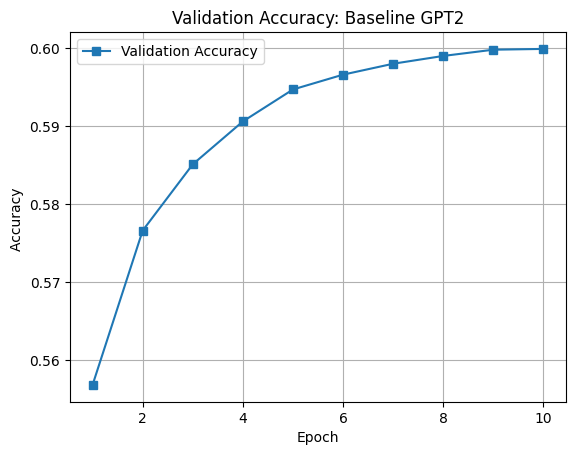

In [ ]:
# Accuracies per epoch
val_acc   = [0.5568, 0.5766, 0.5851, 0.5906, 0.5947, 0.5966, 0.5980, 0.5990, 0.5998, 0.5999]
epochs = list(range(1, 11))




plt.figure()
plt.plot(epochs, val_acc,   marker='s', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy ')
plt.title('Validation Accuracy: Baseline GPT2')
plt.legend()
plt.grid(True)
plt.show()



#Building the model for over encoding
We will use GPT2 and we will replace its embedding layer with ours.



# Over Encoding with m=4

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#embedding layer
oe_emb = OEEmbedding(
    vocab_size=vocab_size,
    model_dim=128,
    m=4,
    max_ngram=3,
    k=4,
    pad_token_id=pad_token_id

)


#Original gpt2 has 12 layers and 12 heads but we want 2.4 M parameters not the original
config = GPT2Config(
    vocab_size=4,
    pad_token_id=3,
    n_embd=128,
    n_layer=12,
    n_head=2,
    n_positions=750, #max length of tokens for each sequence

)

#model creation
model = GPT2LMHeadModel(config)

# Replace its input_embeddings layer with ours
model.set_input_embeddings(oe_emb)


#Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4, betas=(0.9, 0.98),
    weight_decay=0.1
)

#Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

#Loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id)

model.to(device)


Using device: cuda


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): OEEmbedding(
      (e1): Embedding(4, 128)
      (ngram_embeddings): ModuleList(
        (0): Embedding(4, 16)
        (1): Embedding(6, 16)
        (2): Embedding(8, 16)
        (3): Embedding(10, 16)
        (4): Embedding(12, 16)
        (5): Embedding(14, 16)
        (6): Embedding(16, 16)
        (7): Embedding(18, 16)
      )
      (ngram_projs): ModuleList(
        (0-7): 8 x Linear(in_features=16, out_features=128, bias=True)
      )
    )
    (wpe): Embedding(750, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_a

In [ ]:
# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters:     {total_params:,}")


Total parameters:     2,495,360


In [ ]:
#Training
epochs = 10


for epoch in range(epochs):
    model.train()
    total_loss = 0
    for (input_ids,) in train_loader:
        input_ids = input_ids.to(device)

        optimizer.zero_grad()

        # Access the logits tensor from the model's output object
        model_output = model(input_ids[:, :-1])
        logits = model_output.logits # Get the logits tensor

        labels = input_ids[:, 1:].reshape(-1)

        # Now reshape the actual logits tensor
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            labels
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)

    # Accuracy
    val_accuracy = evaluate_accuracy(model, val_loader, pad_token_id=pad_token_id)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Validation Generation Accuracy: {val_accuracy:.4f}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/10 | Train Loss: 0.9142 | Validation Generation Accuracy: 0.5675
Epoch 2/10 | Train Loss: 0.8433 | Validation Generation Accuracy: 0.5787
Epoch 3/10 | Train Loss: 0.8241 | Validation Generation Accuracy: 0.5871
Epoch 4/10 | Train Loss: 0.8100 | Validation Generation Accuracy: 0.5944
Epoch 5/10 | Train Loss: 0.7982 | Validation Generation Accuracy: 0.5982
Epoch 6/10 | Train Loss: 0.7905 | Validation Generation Accuracy: 0.6003
Epoch 7/10 | Train Loss: 0.7857 | Validation Generation Accuracy: 0.6017
Epoch 8/10 | Train Loss: 0.7827 | Validation Generation Accuracy: 0.6023
Epoch 9/10 | Train Loss: 0.7808 | Validation Generation Accuracy: 0.6029
Epoch 10/10 | Train Loss: 0.7797 | Validation Generation Accuracy: 0.6032


As we can see, the over encoding increased our paramaters from 2.4M to 3.7M

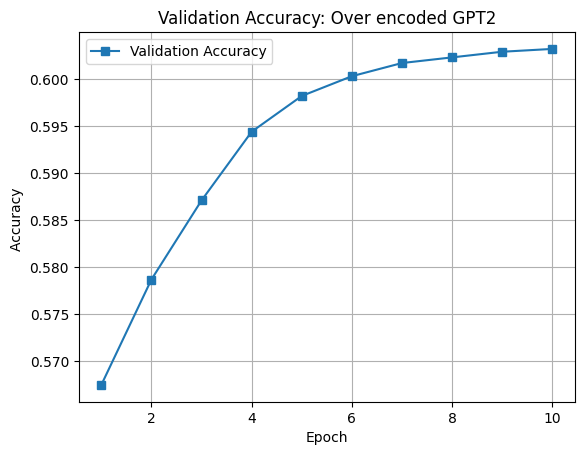

In [ ]:
# Accuracies per epoch
val_acc   = [0.5675, 0.5787, 0.5871, 0.5944, 0.5982, 0.6003, 0.6017, 0.6023, 0.6029, 0.6032]
epochs = list(range(1, 11))




plt.figure()
plt.plot(epochs, val_acc,   marker='s', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy ')
plt.title('Validation Accuracy: Over encoded GPT2')
plt.legend()
plt.grid(True)
plt.show()



#Comparing accuracy in baseline and OE model (m=4)

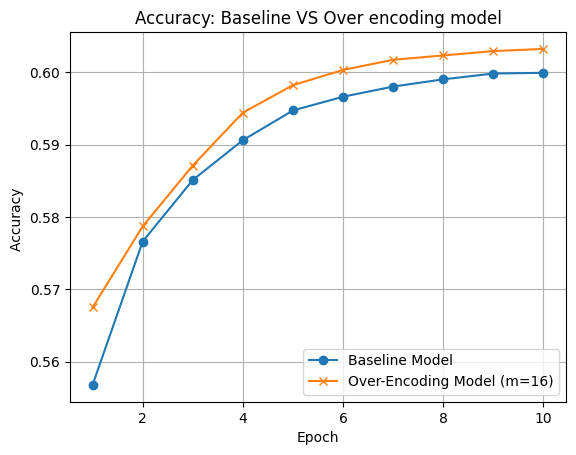

In [1]:
import matplotlib.pyplot as plt
acc_baseline = [0.5568, 0.5766, 0.5851, 0.5906, 0.5947, 0.5966, 0.5980, 0.5990, 0.5998, 0.5999]
acc_OE = [0.5675, 0.5787, 0.5871, 0.5944, 0.5982, 0.6003, 0.6017, 0.6023, 0.6029, 0.6032]
epochs = list(range(1, 11))

plt.figure()
plt.plot(epochs, acc_baseline,   marker='o', label='Baseline Model')
plt.plot(epochs, acc_OE,   marker='x', label='Over-Encoding Model (m=16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy ')
plt.title('Accuracy: Baseline VS Over encoding model')
plt.legend()
plt.grid(True)
plt.show()

# Now we want to observ how m (as well as the size of the vocabulary) affects the loss. We want to find a linear relation between loss and vocabulary size so we will test for m=64 (we already tested for m=4)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#embedding layer
oe_emb = OEEmbedding(
    vocab_size=vocab_size,
    model_dim=128,
    m=64,
    max_ngram=3,
    k=4,
    pad_token_id=pad_token_id

)


#Original gpt2 has 12 layers and 12 heads but we want 2.4 M parameters not the original
config = GPT2Config(
    vocab_size=4,
    pad_token_id=3,
    n_embd=128,
    n_layer=12,
    n_head=2,
    n_positions=750, #max length of tokens for each sequence

)

#model creation
model = GPT2LMHeadModel(config)

# Replace its input_embeddings layer with ours
model.set_input_embeddings(oe_emb)


#Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4, betas=(0.9, 0.98),
    weight_decay=0.1
)

#Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

#Loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id)

model.to(device)


Using device: cuda


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): OEEmbedding(
      (e1): Embedding(4, 128)
      (ngram_embeddings): ModuleList(
        (0): Embedding(64, 16)
        (1): Embedding(66, 16)
        (2): Embedding(68, 16)
        (3): Embedding(70, 16)
        (4): Embedding(72, 16)
        (5): Embedding(74, 16)
        (6): Embedding(76, 16)
        (7): Embedding(78, 16)
      )
      (ngram_projs): ModuleList(
        (0-7): 8 x Linear(in_features=16, out_features=128, bias=True)
      )
    )
    (wpe): Embedding(750, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=384, nx=128)
          (c_proj): Conv1D(nf=128, nx=128)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwis

In [ ]:
# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters:     {total_params:,}")


Total parameters:     2,503,040


In [ ]:
#Training
epochs = 10


for epoch in range(epochs):
    model.train()
    total_loss = 0
    for (input_ids,) in train_loader:
        input_ids = input_ids.to(device)

        optimizer.zero_grad()

        # Access the logits tensor from the model's output object
        model_output = model(input_ids[:, :-1])
        logits = model_output.logits # Get the logits tensor

        labels = input_ids[:, 1:].reshape(-1)

        # Now reshape the actual logits tensor
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            labels
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)

    # Accuracy
    val_accuracy = evaluate_accuracy(model, val_loader, pad_token_id=pad_token_id)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Validation Generation Accuracy: {val_accuracy:.4f}")

Epoch 1/10 | Train Loss: 0.9176 | Validation Generation Accuracy: 0.5688
Epoch 2/10 | Train Loss: 0.8413 | Validation Generation Accuracy: 0.5791
Epoch 3/10 | Train Loss: 0.8229 | Validation Generation Accuracy: 0.5880
Epoch 4/10 | Train Loss: 0.8097 | Validation Generation Accuracy: 0.5938
Epoch 5/10 | Train Loss: 0.7990 | Validation Generation Accuracy: 0.5976
Epoch 6/10 | Train Loss: 0.7914 | Validation Generation Accuracy: 0.6002
Epoch 7/10 | Train Loss: 0.7860 | Validation Generation Accuracy: 0.6018
Epoch 8/10 | Train Loss: 0.7826 | Validation Generation Accuracy: 0.6025
Epoch 9/10 | Train Loss: 0.7806 | Validation Generation Accuracy: 0.6030
Epoch 10/10 | Train Loss: 0.7795 | Validation Generation Accuracy: 0.6032


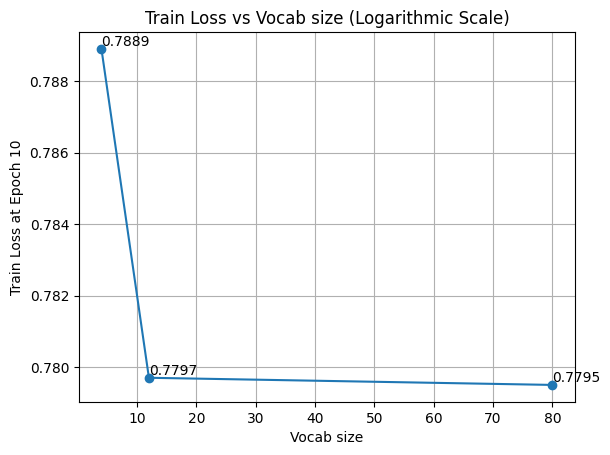

In [ ]:
import matplotlib.pyplot as plt

vocab_size = [4, 12, 80]
losses = [0.7889,  0.7797, 0.7795]

# Plot
plt.figure()
plt.plot(vocab_size, losses, marker='o')
plt.xlabel('Vocab size')
plt.ylabel('Train Loss at Epoch 10')
plt.title('Train Loss vs Vocab size (Logarithmic Scale)')
plt.grid(True)

# Annotate each point
for x, y in zip(vocab_size, losses):
    plt.text(x, y, f'{y:.4f}', ha='left', va='bottom')

plt.show()


#Some extra plots


#Loss over epochs for different models

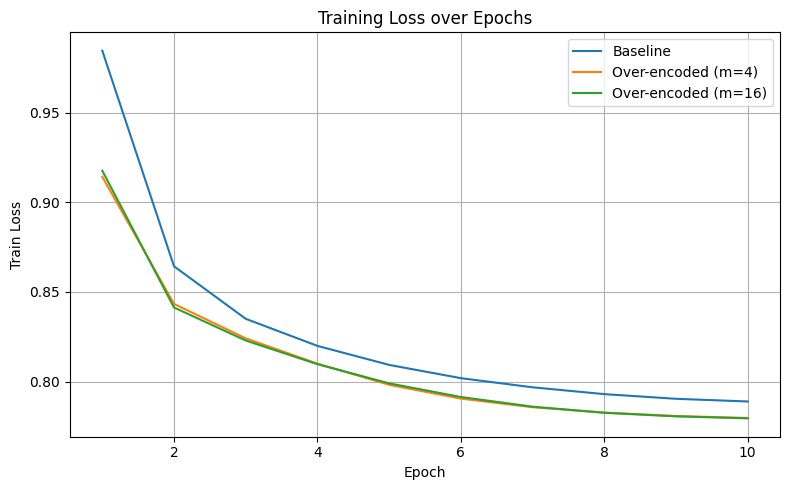

In [ ]:

# Loss values for each model
baseline_losses = [0.9845, 0.8643, 0.8350, 0.8199, 0.8093, 0.8019, 0.7968, 0.7930, 0.7904, 0.7889]
over_encoded_m1 = [0.9142, 0.8433, 0.8241, 0.8100, 0.7982, 0.7905, 0.7857, 0.7827, 0.7808, 0.7797]
over_encoded_m2 = [0.9176, 0.8413, 0.8229, 0.8097, 0.7990, 0.7914, 0.7860, 0.7826, 0.7806, 0.7795]


epochs = list(range(1, 11))

plt.figure(figsize=(8, 5))
plt.plot(epochs, baseline_losses, label='Baseline')
plt.plot(epochs, over_encoded_m1, label='Over-encoded (m=4)')
plt.plot(epochs, over_encoded_m2, label='Over-encoded (m=16)')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Accuracy over epocs for different models

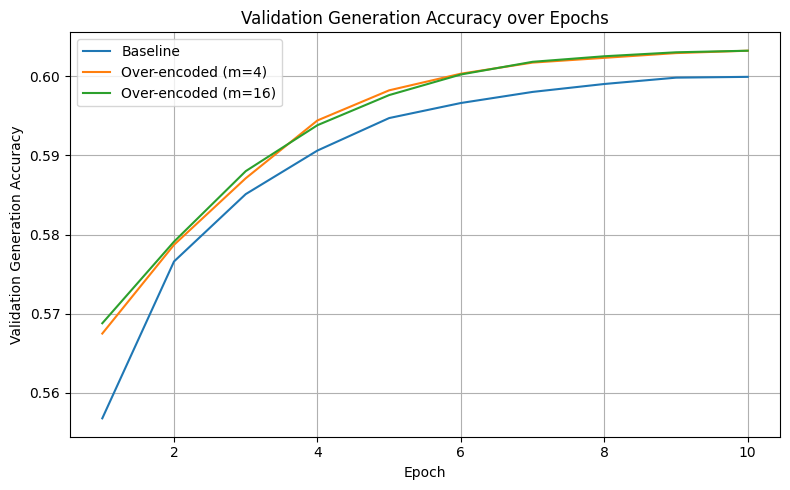

In [ ]:
# Accuracy values for each model
baseline_acc = [0.5568, 0.5766, 0.5851, 0.5906, 0.5947, 0.5966, 0.5980, 0.5990, 0.5998, 0.5999]
over_encoded_m1_acc = [0.5675, 0.5787, 0.5871, 0.5944, 0.5982, 0.6003, 0.6017, 0.6023, 0.6029, 0.6032]
over_encoded_m2_acc = [0.5688, 0.5791, 0.5880, 0.5938, 0.5976, 0.6002, 0.6018, 0.6025, 0.6030, 0.6032]

epochs = list(range(1, 11))

plt.figure(figsize=(8, 5))
plt.plot(epochs, baseline_acc, label='Baseline')
plt.plot(epochs, over_encoded_m1_acc, label='Over-encoded (m=4)')
plt.plot(epochs, over_encoded_m2_acc, label='Over-encoded (m=16)')
plt.xlabel('Epoch')
plt.ylabel('Validation Generation Accuracy')
plt.title('Validation Generation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
